In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("notebooks/distilled_models", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from config import Config
from data.dataset import NetworkDataset, load_datasets
from utils.plot import plot_precision_recall_f1, plot_fpr_tpr_roc_auc, plot_loss
from model_config import CNN_models, MLP_Models, LSTM_Models, GRU_Models
from compact.knowledge_distillation import KnowledgeDistillation

In [2]:
conf = Config()
#load_models = MLP_Models()
#load_models = LSTM_Models()
#load_models = GRU_Models()
load_models = CNN_models()
teacher_conf = load_models.cnn_4
student_conf = load_models.light_cnn_4
teacher_model = load_models.get_model(teacher_conf)
teacher_model.load()
student_model = load_models.get_model(student_conf)

kd = KnowledgeDistillation(
    teacher=teacher_model,
    student=student_model,
    device=conf.device,
    model_type=load_models.type,
    distillation=student_conf["distill_type"]
)

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/large_model/cnn_4.pth!


In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_datasets(conf.datasets, load_models.type)

print(X_train.shape)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, conf.batch_size, shuffle=True, num_workers=8)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, conf.batch_size, shuffle=True, num_workers=8)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, conf.batch_size, shuffle=True, num_workers=8)

torch.Size([356334, 1, 513])


In [4]:
train_metrics, train_loss, val_loss = kd.train_kd(train_loader, val_loader, conf.epochs)

Epoch: 1/10, Macro-F1 score: 0.56, Micro-F1 score: 0.84, Macro ROC AUC score: 0.96, Train loss: 0.049, Val loss: 0.266
Epoch: 2/10, Macro-F1 score: 0.65, Micro-F1 score: 0.87, Macro ROC AUC score: 0.97, Train loss: 0.022, Val loss: 0.200
Epoch: 3/10, Macro-F1 score: 0.68, Micro-F1 score: 0.88, Macro ROC AUC score: 0.98, Train loss: 0.016, Val loss: 0.186
Epoch: 4/10, Macro-F1 score: 0.69, Micro-F1 score: 0.88, Macro ROC AUC score: 0.98, Train loss: 0.015, Val loss: 0.177
Epoch: 5/10, Macro-F1 score: 0.69, Micro-F1 score: 0.89, Macro ROC AUC score: 0.98, Train loss: 0.014, Val loss: 0.168
Epoch: 6/10, Macro-F1 score: 0.71, Micro-F1 score: 0.89, Macro ROC AUC score: 0.98, Train loss: 0.014, Val loss: 0.158
Epoch: 7/10, Macro-F1 score: 0.71, Micro-F1 score: 0.89, Macro ROC AUC score: 0.98, Train loss: 0.013, Val loss: 0.152
Epoch: 8/10, Macro-F1 score: 0.71, Micro-F1 score: 0.89, Macro ROC AUC score: 0.98, Train loss: 0.013, Val loss: 0.153
Epoch: 9/10, Macro-F1 score: 0.72, Micro-F1 scor

In [5]:
test_loss, metrics = student_model.evaluate(test_loader)
print(f"Macro-F1 score: {metrics['f1_macro']:.2f}, Micro-F1 score: {metrics['f1_micro']:.2f}, Macro ROC AUC score: {metrics['roc_auc_macro']:.2f}")

Macro-F1 score: 0.72, Micro-F1 score: 0.89, Macro ROC AUC score: 0.98


In [6]:
student_model.save()

Checkpoint saved at /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/compressed_model/light_cnn_4.pth


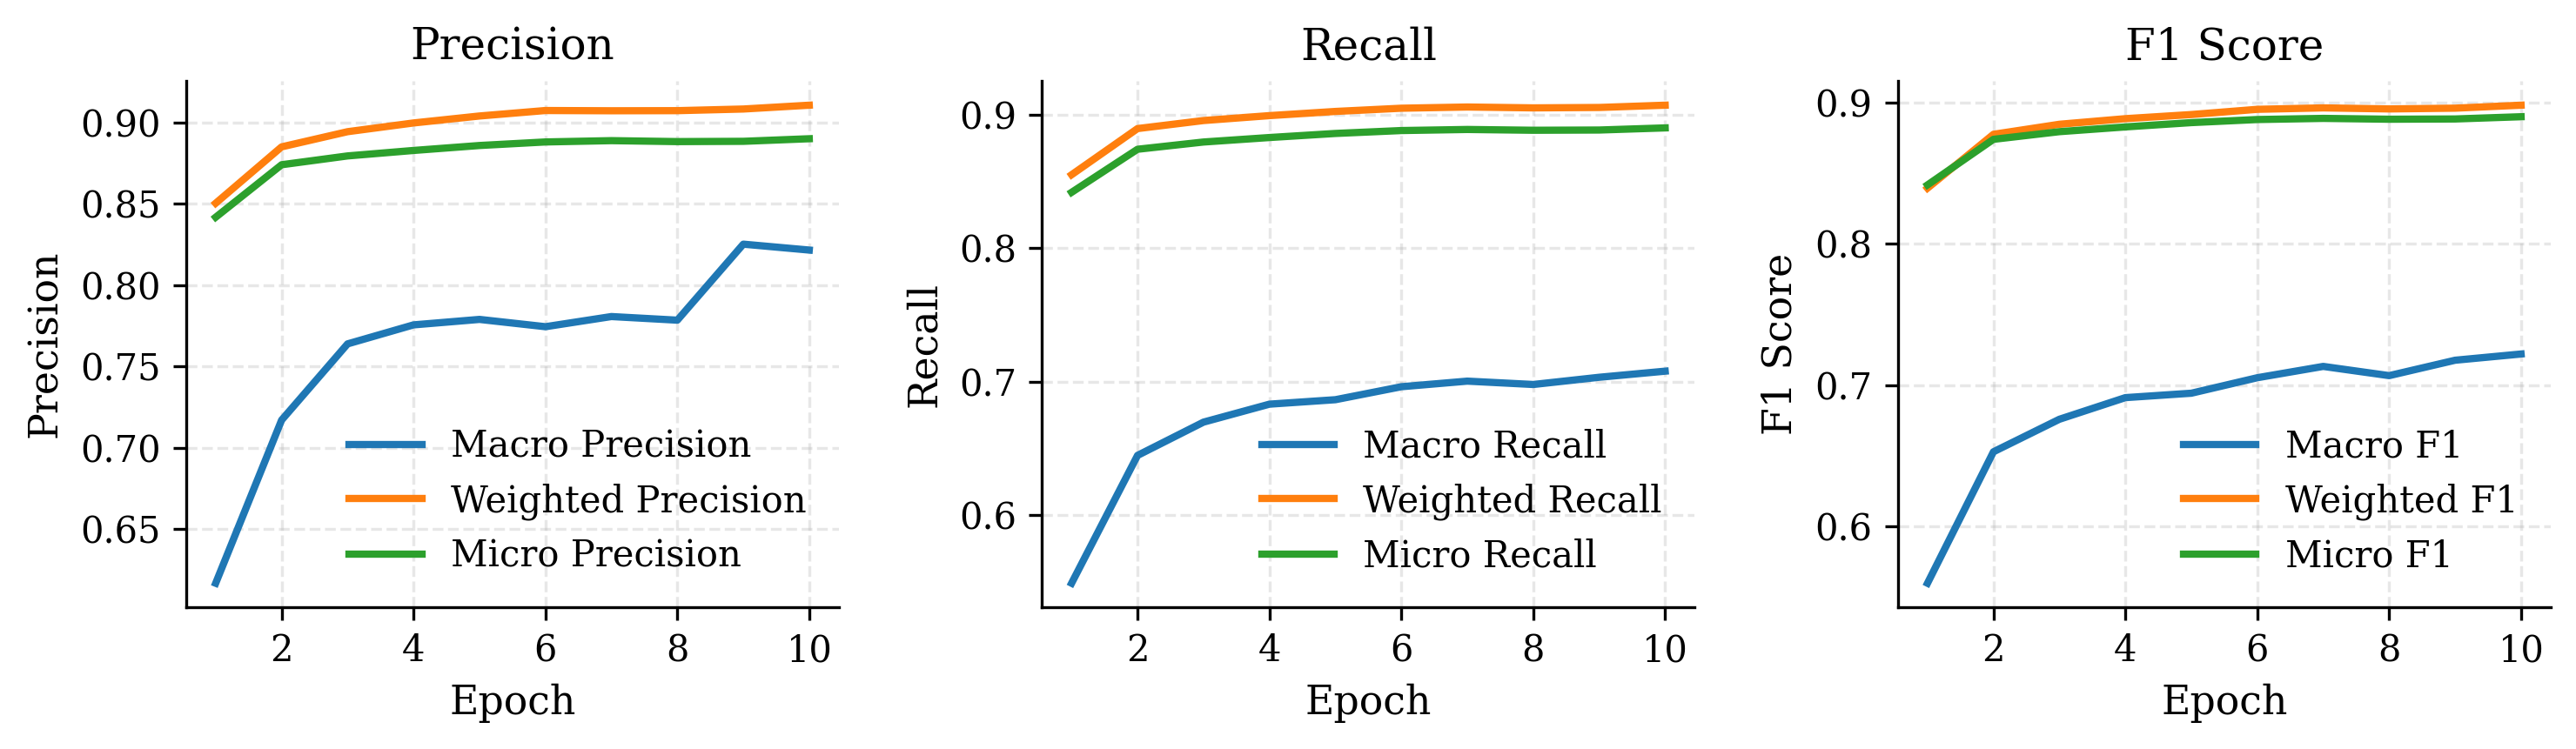

In [7]:
train_plot_path = os.path.join(os.getcwd().replace("notebooks/distilled_models", ""), "plots", "distillation", student_conf["distill_type"], "train_" + student_conf["name"] + ".png")
plot_precision_recall_f1(train_metrics, train_plot_path)

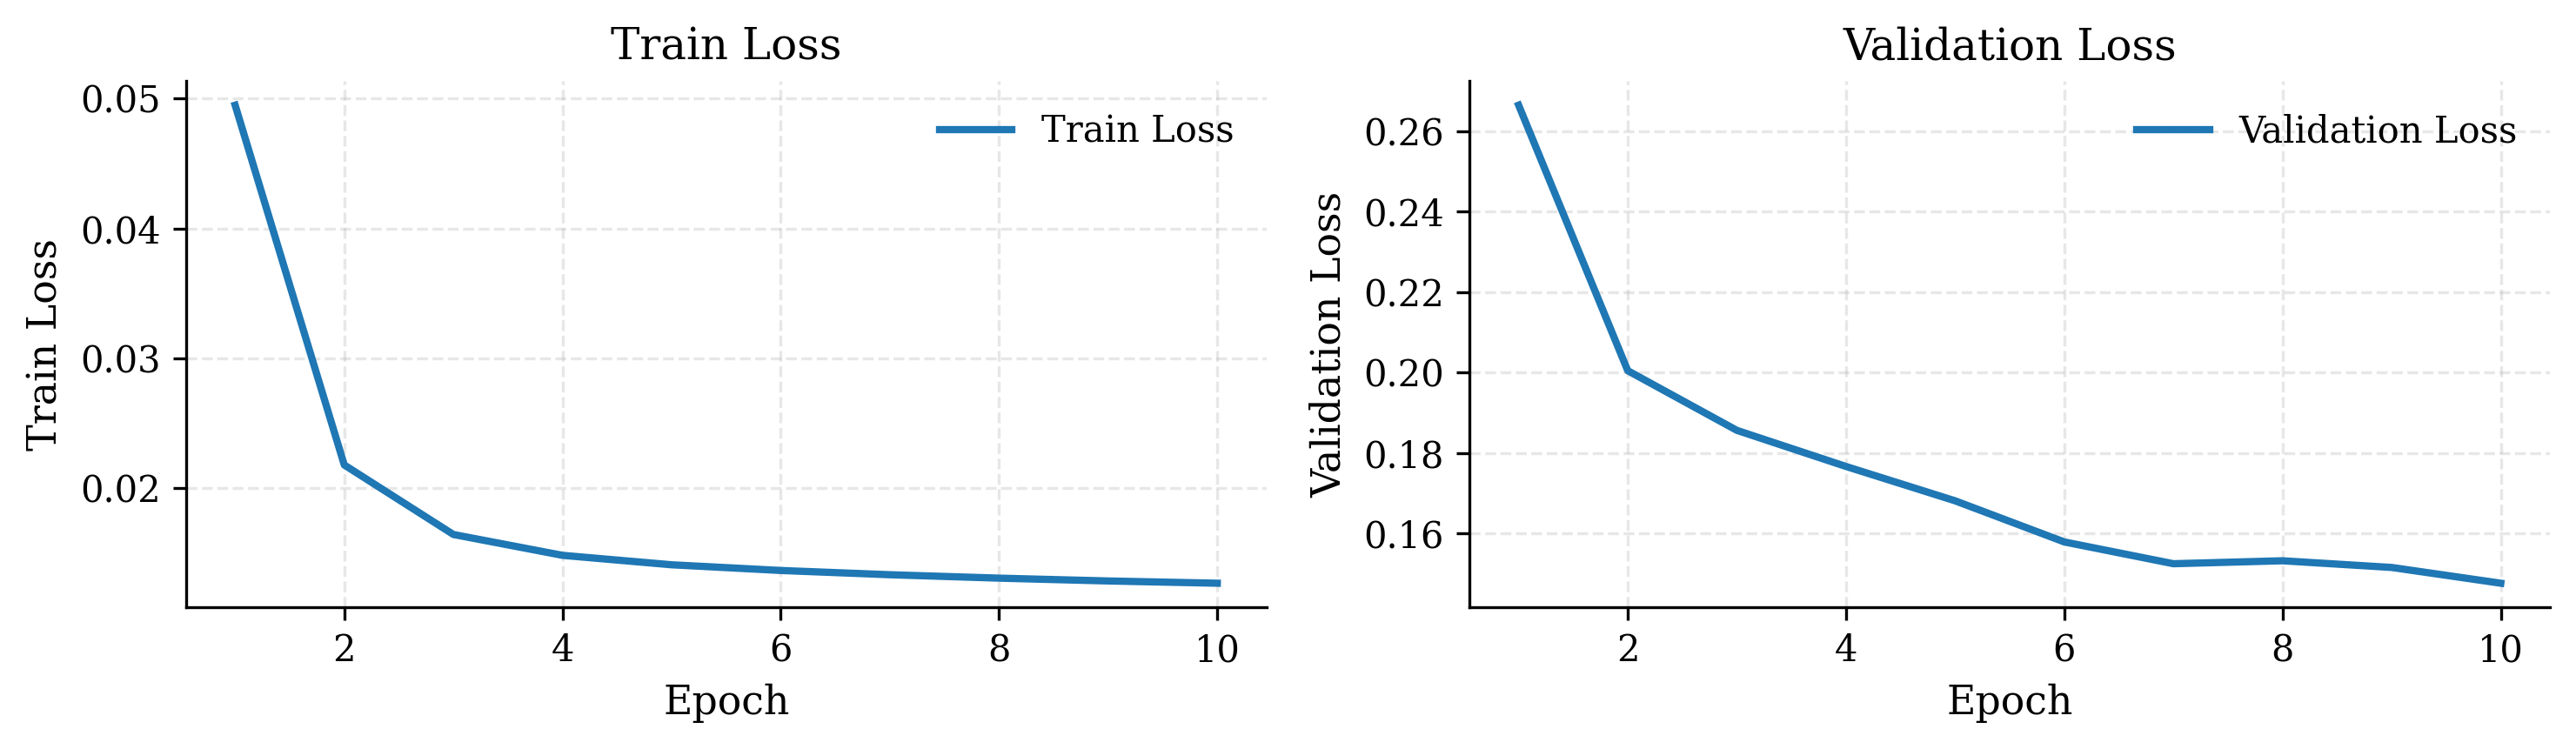

In [8]:
loss_plot_path = os.path.join(os.getcwd().replace("notebooks/distilled_models", ""), "plots", "distillation", student_conf["distill_type"], "loss_" + student_conf["name"] + ".png")
plot_loss(train_loss, val_loss, loss_plot_path)

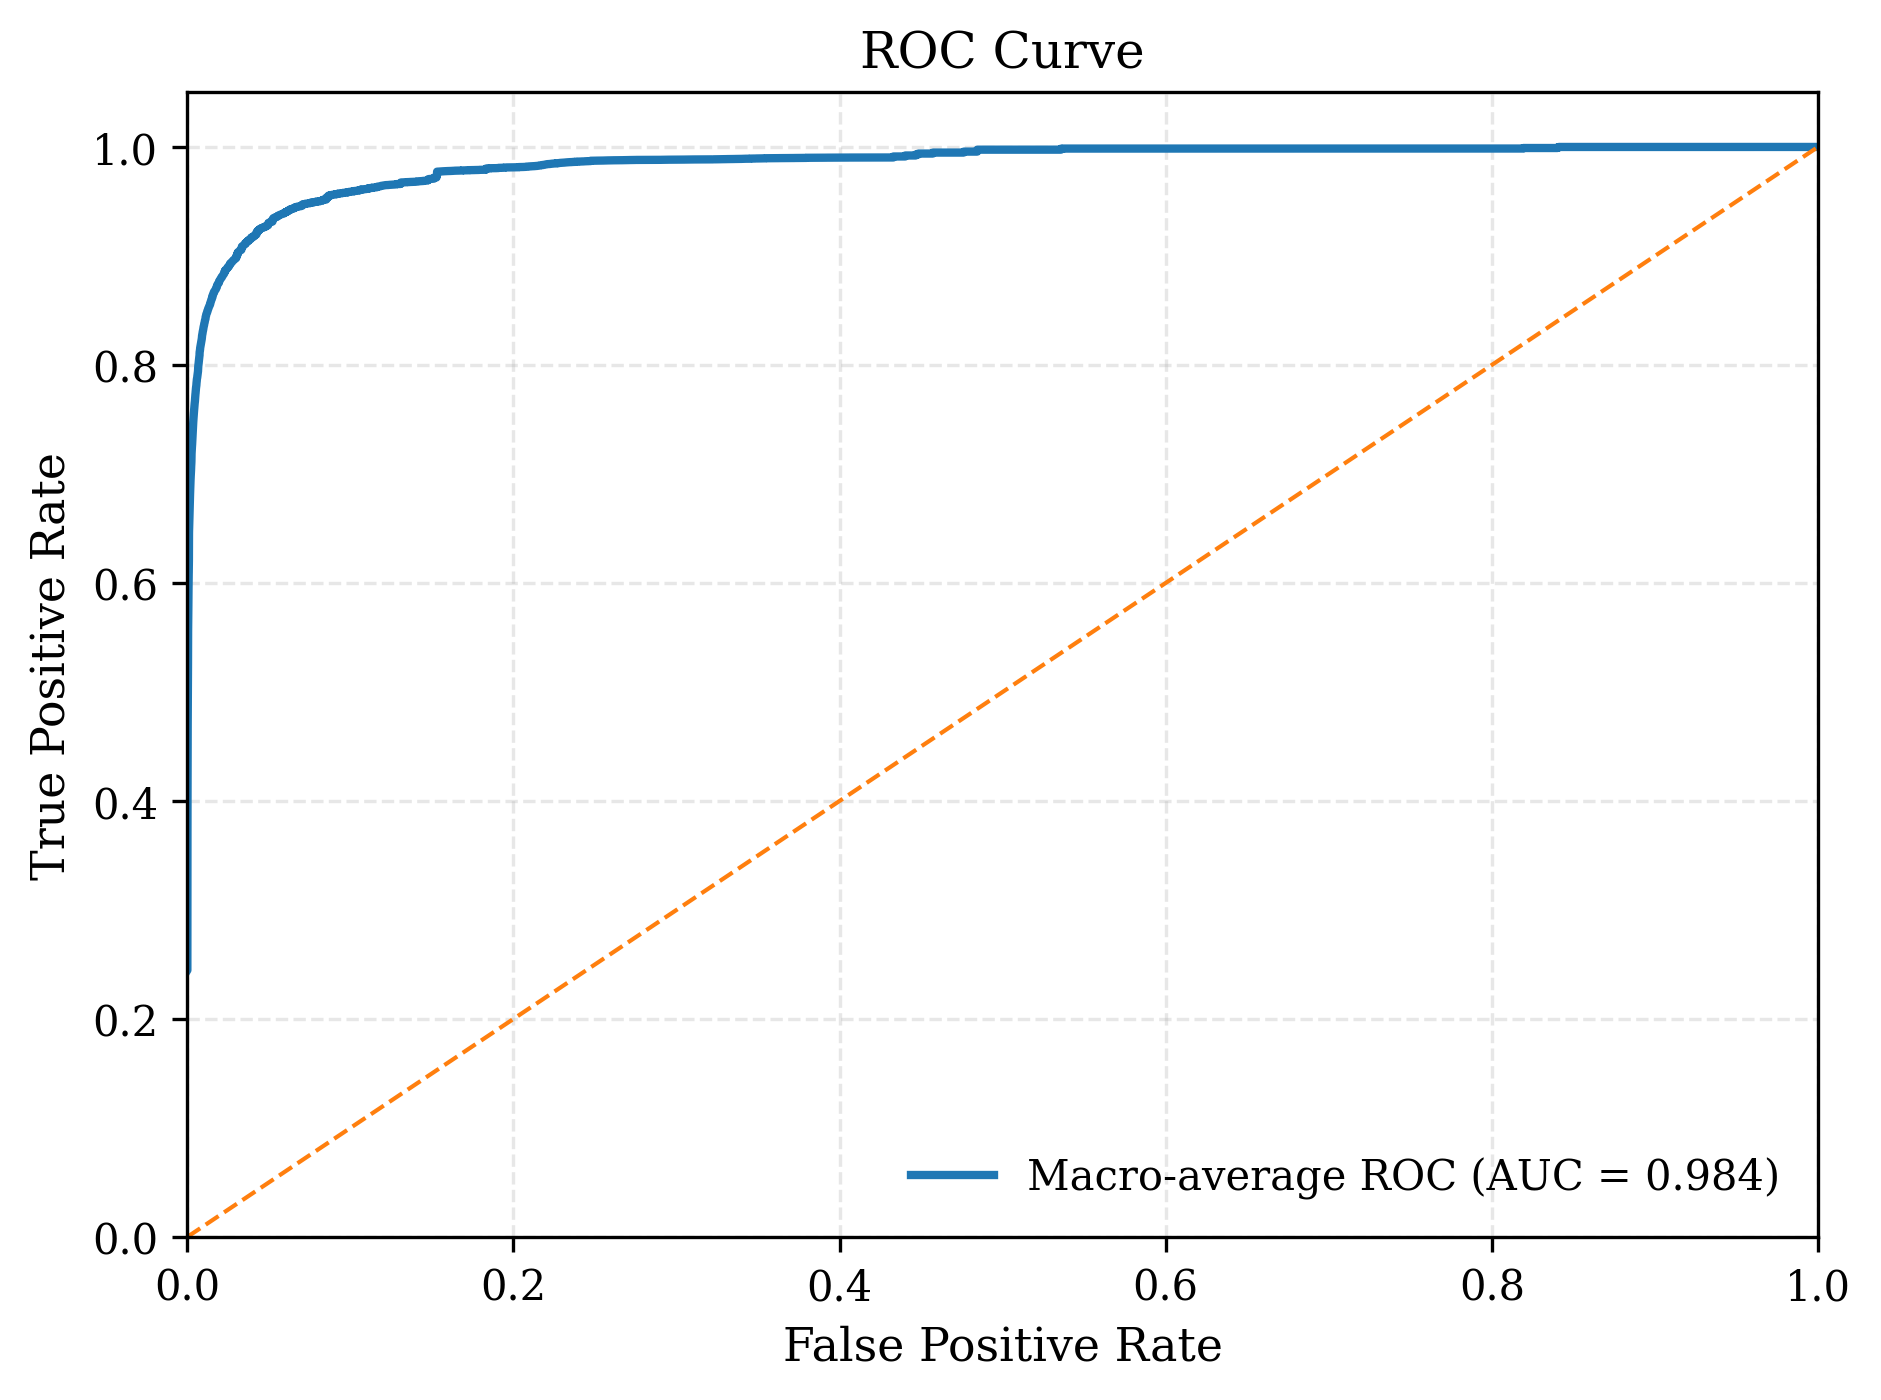

In [9]:
roc_auc_path = os.path.join(os.getcwd().replace("notebooks/distilled_models", ""), "plots", "distillation", student_conf["distill_type"], "roc_auc_" + student_conf["name"] + ".png")
plot_fpr_tpr_roc_auc(metrics, roc_auc_path)